<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/BaselineUOnes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
from torchvision.models import *
from utils import *
import pandas as pd
from pathlib import Path

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD" -O CheXpert-v1.0-small.zip && rm -rf /tmp/cookies.txt

--2020-05-11 07:24:08--  https://docs.google.com/uc?export=download&confirm=lelD&id=14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD
Resolving docs.google.com (docs.google.com)... 64.233.189.138, 64.233.189.102, 64.233.189.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-38-docs.googleusercontent.com/docs/securesc/v4jk6pv2k0mog445t544erf9ra18ck6c/rtpum6jtde1m17vrh4596cvupnacq8ta/1589181825000/11336251244391618301/17978464669561722367Z/14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD?e=download [following]
--2020-05-11 07:24:08--  https://doc-04-38-docs.googleusercontent.com/docs/securesc/v4jk6pv2k0mog445t544erf9ra18ck6c/rtpum6jtde1m17vrh4596cvupnacq8ta/1589181825000/11336251244391618301/17978464669561722367Z/14yeXGJ9TjAA-Gh7GvGQuYlV8h099ZufD?e=download
Resolving doc-04-38-docs.googleusercontent.com (doc-04-38-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting

In [0]:
!unzip -qq CheXpert-v1.0-small.zip
!rm CheXpert-v1.0-small.zip

Data PreProcessing

In [0]:
full_train_df = pd.read_csv('./CheXpert-v1.0-small/train.csv')
full_train_df['train_valid'] = False
full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
full_train_df  ['study'] = full_train_df.Path.str.split('/',4,True)[3]

In [0]:
full_valid_df = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
full_valid_df['train_valid'] = True
full_valid_df['patient'] = full_valid_df.Path.str.split('/',3,True)[2]
full_valid_df  ['study'] = full_valid_df.Path.str.split('/',4,True)[3]

In [0]:
# function to create class labels
def feature_string(row):
    feature_list = []
    for feature in chexpert_targets:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
    
    return ';'.join(feature_list)

In [0]:
full_df = pd.concat([full_train_df, full_valid_df])
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [6]:
full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,False,patient00001,study1,
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,False,patient00002,study2,Atelectasis;Cardiomegaly;Consolidation;Edema;P...
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,Consolidation
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,patient00002,study1,Consolidation
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,False,patient00003,study1,Edema


In [7]:
full_df.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string
229,CheXpert-v1.0-small/valid/patient64736/study1/...,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64736,study1,
230,CheXpert-v1.0-small/valid/patient64737/study1/...,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64737,study1,
231,CheXpert-v1.0-small/valid/patient64738/study1/...,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,patient64738,study1,Cardiomegaly;Edema
232,CheXpert-v1.0-small/valid/patient64739/study1/...,Female,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,patient64739,study1,
233,CheXpert-v1.0-small/valid/patient64740/study1/...,Male,90,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,True,patient64740,study1,Atelectasis;Pleural Effusion


In [0]:
tfms = get_transforms(do_flip=False, max_zoom=1.0, max_lighting=0.1)

In [0]:
src = ImageList.from_df(full_df, '.', 'Path').split_from_df('train_valid').label_from_df('feature_string',label_delim=';')

In [0]:
data = src.transform(tfms, size=320, padding_mode='zeros', resize_method=ResizeMethod.PAD).databunch(bs=40).normalize(imagenet_stats)

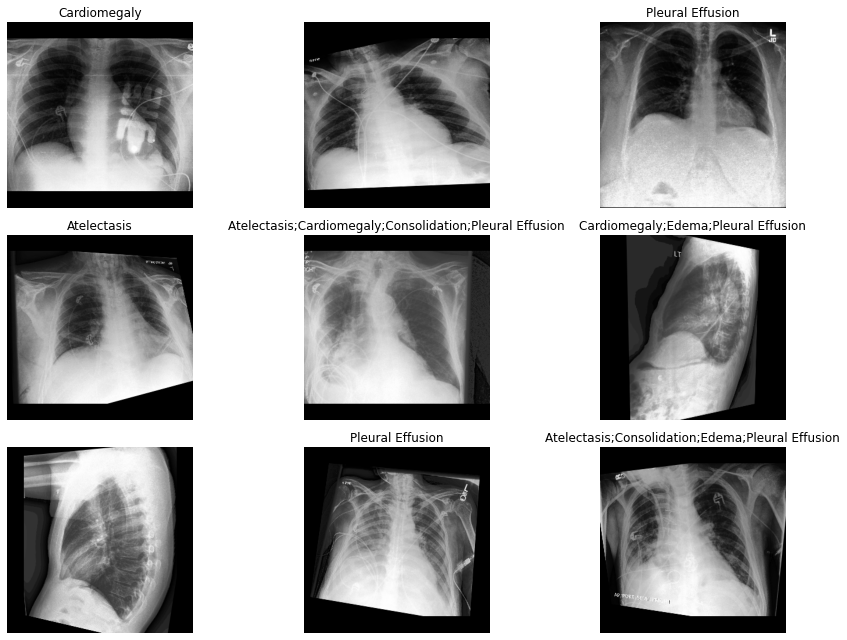

In [11]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
learn = cnn_learner(data, models.densenet121, pretrained=True, metrics=avg_auc_metric)

epoch,train_loss,valid_loss,avg_auc_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.00E-02


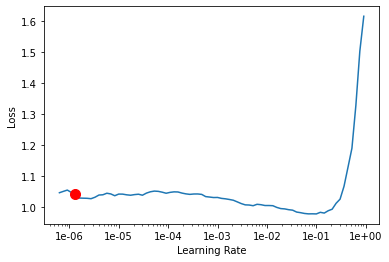

In [13]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 3e-2

In [0]:
learn.fit_one_cycle(6, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='avg_auc_metric')])

epoch,train_loss,valid_loss,avg_auc_metric,time
